# 1. Introduction <a name="introduction"></a>

Dans ce Notebook, nous allons répondre à l'exercice : **Forecasting Intra-Day Prices in the GB Power Market**.  
L'objectif est de prédire le **prix intra-day (ID)** publié deux heures avant la livraison, en exploitant différentes sources de données publiques (prix Day-Ahead, indicateurs de demande, etc.).

---

## Pourquoi l'Intra-Day Price est-il crucial ?

- **Optimisation du dispatch** : Les producteurs et fournisseurs doivent ajuster en temps quasi-réel leur offre afin d’équilibrer la demande. Une prévision précise de l’ID Price leur permet de décider des quantités à injecter ou à retirer du marché au meilleur moment.
- **Gestion du risque (hedging)** : Les acteurs du marché (traders, utilities, etc.) utilisent le prix intra-day pour couvrir leurs positions ou saisir des opportunités de trading en dernière minute.
- **Stabilité du réseau** : Un bon modèle de prévision aide également le gestionnaire de réseau à anticiper les tensions d’offre/demande et à minimiser les risques de déséquilibre.

---

## Données et Période d'Étude

- **Période couverte** : du 1er janvier 2024 au 15 février 2025.  
- **Taille du dataset** : environ 35 000 lignes après nettoyage et agrégation.  
- **Colonnes clés** :  
  - *TSDF, NDF* : prévisions de la demande (Transmission System Demand Forecast, National Demand Forecast).  
  - *INDDEM, MELNGC, IMBALNGC* : Indicated Demand, Margin, Imbalance, fournissant des informations sur le surplus ou déficit d’énergie.  
  - *SBP* : System Buy Price (cible de notre prévision).  
  - *reserveScarcityPrice* : indicateur de tension (peut influencer fortement les pics de prix).  
  - *Autres variables temporelles* (heure, jour, mois, etc.) pour capturer la saisonnalité.

# 2. Imports et Configuration <a name="imports-et-configuration"></a>

In [1]:
import os
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import xgboost as xgb
import time

from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration globale
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.max_columns = 50

# 3. Chargement des données <a name="chargement-des-données"></a>

Nous allons maintenant définir plusieurs fonctions permettant de récupérer les donnée 
depuis l'API Elexon/BMRS (demand forecast, indicated forecast, system prices. 
Ensuite, nous fusionnerons ces données en un seul DataFrame via `merge_data_for_perid`.


In [2]:
def generate_date_chunks(start_date, end_date, chunk_size_days=7):
    """
    Génère des intervalles de date (start, end) de taille maximum `chunk_size_days`. Utile pour appeler l'API sur de petites fenêtres (7 jours) afin d'éviter les limites.
    """
    start = pd.to_datetime(start_date)
    end   = pd.to_datetime(end_date)
    current = start
    
    while current <= end:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end:
            chunk_end = end
        yield (current.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d"))
        current = chunk_end + pd.Timedelta(days=1)

def fetch_demand_forecast_day_ahead_chunked(start_date: str, end_date: str, output_format: str = "json", boundary: str = None) -> pd.DataFrame:
    """
    Récupère la Day-Ahead Demand Forecast (NDF, TSDF) en segmentant la période en chunks de 7 jours,
    via l'endpoint /forecast/demand/day-ahead/latest
    :return: pd.DataFrame concaténé de toutes les réponses
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/demand/day-ahead/latest"
    all_dfs = []

    for (chunk_start, chunk_end) in generate_date_chunks(start_date, end_date, 7):
        params = {
            "from": f"{chunk_start}T00:00:00Z",
            "to":   f"{chunk_end}T23:59:59Z",
            "format": output_format
        }
        if boundary:
            params["boundary"] = boundary
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (utiliser 'json' ou 'csv').")
        else:
            print(f"[Warning] Erreur API [{r.status_code}] sur {chunk_start} - {chunk_end}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()
    
    df_final = pd.concat(all_dfs, ignore_index=True)
    return df_final

def fetch_indicated_day_ahead_evolution_range(start_date: str, end_date: str, output_format: str = "json", boundary: str = None) -> pd.DataFrame:
    """
    Récupère l'evolution indicated day-ahead forecast (INDDEM, INDGEN, IMBALNGC, MELNGC)
    via /forecast/indicated/day-ahead/evolution, en bouclant sur chaque jour + settlementPeriod=1..48.
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/indicated/day-ahead/evolution"
    sp_params = [("settlementPeriod", str(i)) for i in range(1, 49)]
    all_dfs = []
    
    date_range = pd.date_range(start_date, end_date, freq='D')
    for d in date_range:
        date_str = d.strftime("%Y-%m-%d")

        base_params = [("settlementDate", date_str), ("format", output_format)]
        params = base_params + sp_params
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                # On vérifie si la racine est un dict contenant "data"
                if isinstance(data_json, dict):
                    data_list = data_json.get("data", [])
                    if data_list:
                        df_chunk = pd.DataFrame(data_list)
                        all_dfs.append(df_chunk)
                else:
                    print(f"[Warning] Structure inattendue pour date={date_str}: {type(data_json)}")
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (utiliser 'json' ou 'csv').")
        else:
            print(f"[Warning] Erreur API [{r.status_code}] pour date={date_str}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()

    return pd.concat(all_dfs, ignore_index=True)

def fetch_system_prices_one_day(settlement_date: str, output_format: str = "json") -> pd.DataFrame:
    """
    Récupère System Price (SBP, SSP, NIV) pour 1 jour
    :return: pd.DataFrame
    """
    base_url = f"https://data.elexon.co.uk/bmrs/api/v1/balancing/settlement/system-prices/{settlement_date}"
    params = {"format": output_format}

    r = requests.get(base_url, params=params)
    if r.status_code == 200:
        if output_format == "json":
            data_json = r.json()
            data = data_json.get("data", [])
            df = pd.DataFrame(data)
            return df
        elif output_format == "csv":
            df = pd.read_csv(StringIO(r.text))
            return df
        else:
            raise ValueError("Format non géré (utiliser 'json' ou 'csv').")
    else:
        print(f"[Warning] Erreur API ({r.status_code}) pour {settlement_date}: {r.text}")
        return pd.DataFrame()

def fetch_system_prices_range_day_by_day(start_date: str, end_date: str, output_format="json") -> pd.DataFrame:
    """
    Boucle sur chaque journée entre start_date et end_date pour récupérer System Prices (SBP, SSP, NIV) via fetch_system_prices_one_day.
    """
    date_range = pd.date_range(start_date, end_date, freq='D')
    list_sp = []
    for d in date_range:
        d_str = d.strftime("%Y-%m-%d")
        df_day = fetch_system_prices_one_day(d_str, output_format=output_format)
        if not df_day.empty:
            list_sp.append(df_day)
    if list_sp:
        return pd.concat(list_sp, ignore_index=True)
    else:
        return pd.DataFrame()

def fetch_market_index_data_chunked(start_date: str, end_date: str, data_providers: list = ["N2EXMIDP"], chunk_size_days: int = 7, output_format: str = "json" ) -> pd.DataFrame: # or data_providers: list = ["N2EXMIDP","APXMIDP"]
    """
    Récupère Market Index Data (MID) via /datasets/MID en segmentant la période [start_date, end_date] en chunks de `chunk_size_days`.
    return: pd.DataFrame
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/MID"
    all_dfs = []

    for (chunk_start, chunk_end) in generate_date_chunks(start_date, end_date, chunk_size_days):
        params = { "from": f"{chunk_start}T00:00:00Z", "to":   f"{chunk_end}T23:59:59Z", "format": output_format}

        dp_tuples = [("dataProviders", dp) for dp in data_providers]
        params_list = list(params.items()) + dp_tuples

        r = requests.get(base_url, params=params_list)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (choisir 'json' ou 'csv').")
        else:
            print(f"[Warning] Erreur API MID [{r.status_code}] du {chunk_start} au {chunk_end}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()

    df_final = pd.concat(all_dfs, ignore_index=True)
    return df_final

def fetch_fuelhh_chunked(start_date: str, end_date: str, chunk_size_days: int = 7, output_format: str = "json") -> pd.DataFrame:
    """
    Récupère la half-hourly generation outturn (FUELHH) via /datasets/FUELHH, en segmentant la période [start_date, end_date].
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/FUELHH"
    all_dfs = []
    
    current = pd.to_datetime(start_date)
    end_dt  = pd.to_datetime(end_date)
    
    while current <= end_dt:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end_dt:
            chunk_end = end_dt
        
        params = { "settlementDateFrom": current.strftime("%Y-%m-%d"), "settlementDateTo":   chunk_end.strftime("%Y-%m-%d"), "format": output_format}
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (json ou csv).")
        else:
            print(f"[Warning] FUELHH: HTTP {r.status_code} pour {current.date()} à {chunk_end.date()}: {r.text}")
        
        current = chunk_end + pd.Timedelta(days=1)
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

def pivot_fuelhh(df_fuelhh: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot pour avoir 1 ligne par (settlementDate, settlementPeriod, startTime), et des colonnes fuelType => generation.
    """
    if df_fuelhh.empty:
        return df_fuelhh
    
    df_pivot = df_fuelhh.pivot_table(index=["settlementDate", "settlementPeriod", "startTime"], columns="fuelType", values="generation", aggfunc="mean"  # ou sum, selon besoin
    ).reset_index()
    
    for c in df_pivot.columns:
        if c not in ["settlementDate", "settlementPeriod", "startTime"]:
            df_pivot.rename(columns={c: f"gen_{c}"}, inplace=True)
    
    return df_pivot

def to_datetime_index_fuelhh(df: pd.DataFrame, time_col="startTime") -> pd.DataFrame:
    """
    Convertit le pivot FUELHH en datetime index (colonne 'startTime' => 'datetime').
    """
    if df.empty:
        return df
    
    if time_col in df.columns:
        df["datetime"] = pd.to_datetime(df[time_col], utc=True, errors='coerce')
    else:
        if {"settlementDate","settlementPeriod"}.issubset(df.columns):
            df["datetime"] = (pd.to_datetime(df["settlementDate"]) + pd.to_timedelta((df["settlementPeriod"] - 1)*30, unit='m'))
        else:
            df["datetime"] = pd.NaT
    
    df.set_index("datetime", inplace=True)
    return df

def fetch_windfor_chunked(start_date: str, end_date: str, chunk_size_days: int = 7, output_format: str = "json") -> pd.DataFrame:
    """ Récupère la prévision éolienne (WINDFOR) en segmentant la période [start_date, end_date] """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/WINDFOR"
    all_dfs = []
    
    current = pd.to_datetime(start_date)
    end_dt  = pd.to_datetime(end_date)
    
    while current <= end_dt:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end_dt:
            chunk_end = end_dt
        
        params = {"publishDateTimeFrom": current.strftime("%Y-%m-%dT00:00Z"), "publishDateTimeTo":   chunk_end.strftime("%Y-%m-%dT23:59Z"), "format": output_format}
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (choisir 'json' ou 'csv').")
        else:
            print(f"[Warning] WINDFOR: HTTP {r.status_code} pour {current.date()} - {chunk_end.date()}: {r.text}")
        
        current = chunk_end + pd.Timedelta(days=1)
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

def fetch_loss_of_load_chunked(start_date: str, end_date: str, chunk_size_days: int = 7, output_format: str = "json") -> pd.DataFrame:
    """ Récupère la LoLP & De-rated Margin (LOLPDRM) via /forecast/system/loss-of-load, segmentant la période [start_date, end_date]. """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/system/loss-of-load"
    all_dfs = []
    
    current = pd.to_datetime(start_date)
    end_dt  = pd.to_datetime(end_date)
    
    while current <= end_dt:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end_dt:
            chunk_end = end_dt
        
        params = {"from": f"{current.strftime('%Y-%m-%d')}T00:00Z", "to":   f"{chunk_end.strftime('%Y-%m-%d')}T23:59Z", "format": output_format}
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (json ou csv).")
        else:
            print(f"[Warning] LOLPDRM: HTTP {r.status_code} pour {current.date()} - {chunk_end.date()}: {r.text}")
        
        current = chunk_end + pd.Timedelta(days=1)
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

### Fonctions d'agrégation (Pick Indicated Forecast T-2h) et Merge final

In [4]:
def to_datetime_index(df, time_col="startTime", date_col="settlementDate", period_col="settlementPeriod"):
        if df.empty:
            return df
        if time_col in df.columns:
            df["datetime"] = pd.to_datetime(df[time_col], utc=True, errors='coerce')
        else:
            if date_col in df.columns and period_col in df.columns:
                df["datetime"] = (pd.to_datetime(df[date_col]) + pd.to_timedelta((df[period_col] - 1)*30, unit='m'))
            else:
                df["datetime"] = pd.NaT
        return df
    
def pick_indicated_forecast_t_minus_2h(df_indicated: pd.DataFrame) -> pd.DataFrame:
    """
    Filtre df_indicated pour ne garder qu'une publication par (settlementDate, settlementPeriod, startTime):
      - On calcule T-2h = startTime - 2h
      - On garde les lignes où publishTime <= T-2h
      - Parmi elles, on prend celle dont publishTime est la plus grande (la plus récente avant T-2h)
    
    :param df_indicated: DataFrame Indicated day-ahead
    :return: DataFrame filtré
    """
    if df_indicated.empty:
        return df_indicated

    df_indicated["publishTime_utc"] = pd.to_datetime(df_indicated["publishTime"], utc=True, errors="coerce")
    df_indicated["startTime_utc"]   = pd.to_datetime(df_indicated["startTime"],   utc=True, errors="coerce")

    df_indicated["T_minus_2h"] = df_indicated["startTime_utc"] - pd.Timedelta(hours=2)

    df_filtered = df_indicated[df_indicated["publishTime_utc"] <= df_indicated["T_minus_2h"]].copy()

    if df_filtered.empty:
        return df_filtered  # aucune publication <= T-2h ?

    # Pour chaque (settlementDate, settlementPeriod, startTime_utc), on prend la publication la plus récente (publishTime_utc max)
    df_filtered.sort_values("publishTime_utc", inplace=True)
    df_unique = df_filtered.groupby(
        ["settlementDate","settlementPeriod","startTime_utc"], as_index=False
    ).tail(1).copy()

    df_unique.drop(columns=["publishTime_utc","startTime_utc","T_minus_2h"], inplace=True, errors="ignore")

    return df_unique

def merge_data_for_period(start_date: str, end_date: str, output_format="json", fetch_mid: bool = True, data_providers: list = None, fetch_fuelhh: bool = False, 
                          fetch_windfor: bool = False, fetch_lolpdrm: bool = False, chunk_size_days: int = 7, cache_folder="cache") -> pd.DataFrame:
    """
    Récupère et fusionne:
      - Day-Ahead Demand Forecast
      - Indicated Day-Ahead Forecast (évolution, puis filtré T-2h)
      - System Prices
      - Market Index Data, ect...
    sur la période [start_date, end_date], puis renvoie un DataFrame final.

    :return: DataFrame indexé en datetime, colonnes: TSDF, NDF, INDDEM, INDGEN, IMBALNGC, SBP, etc.
    """
    cache_filename = f"df_merged_{start_date}_{end_date}_mid={fetch_mid}_fuelhh={fetch_fuelhh}_wind={fetch_windfor}_lolp={fetch_lolpdrm}.pkl"
    cache_path = os.path.join(cache_folder, cache_filename)
    
    if os.path.exists(cache_path):
        print(f"[Cache] Loading final merged DataFrame from {cache_path}")
        with open(cache_path, "rb") as f:
            df_cached = pickle.load(f)
        return df_cached
    print("[Info] Cache not found. Fetching & merging data...")
    
    # A) Demand Forecast
    df_demand = fetch_demand_forecast_day_ahead_chunked(start_date, end_date, output_format=output_format)
    # B) Indicated Day-Ahead
    df_indicated = fetch_indicated_day_ahead_evolution_range(start_date, end_date, output_format=output_format)
    # C) System Prices
    df_system_prices = fetch_system_prices_range_day_by_day(start_date, end_date, output_format=output_format)
    # D) Market Index Data (MID)
    if fetch_mid:
        if data_providers is None:
            data_providers = ["N2EXMIDP"]  # Choix par défaut
        df_mid = fetch_market_index_data_chunked(start_date, end_date, data_providers=data_providers, chunk_size_days=chunk_size_days, output_format=output_format)
    else:
        df_mid = pd.DataFrame()

    # E) FUELHH
    if fetch_fuelhh:
        df_fuelhh_raw = fetch_fuelhh_chunked(start_date, end_date, chunk_size_days=chunk_size_days, output_format=output_format)
        df_fuelhh_pivot = pivot_fuelhh(df_fuelhh_raw)
        df_fuelhh_pivot = to_datetime_index_fuelhh(df_fuelhh_pivot)
    else:
        df_fuelhh_pivot = pd.DataFrame()

    # F) WINDFOR
    if fetch_windfor:
        df_windfor_raw = fetch_windfor_chunked(start_date, end_date, chunk_size_days=chunk_size_days, output_format=output_format)
        df_windfor = to_datetime_index(df_windfor_raw)
    else:
        df_windfor = pd.DataFrame()
    
    # G) LOLPDRM
    if fetch_lolpdrm:
        df_lolpdrm_raw = fetch_loss_of_load_chunked(start_date, end_date, chunk_size_days=chunk_size_days, output_format=output_format)
        df_lolpdrm = to_datetime_index(df_lolpdrm_raw)
    else:
        df_lolpdrm = pd.DataFrame()
        
    df_demand       = to_datetime_index(df_demand)
    df_indicated    = to_datetime_index(df_indicated)
    df_system_prices= to_datetime_index(df_system_prices)
    df_mid = to_datetime_index(df_mid)
    
    # Sélectionner la publication T-2h dans df_indicated
    df_indicated = pick_indicated_forecast_t_minus_2h(df_indicated)
    
    # Datetime en index
    for df_ in [df_demand, df_indicated, df_system_prices, df_mid, df_windfor, df_lolpdrm]:
        if not df_.empty and "datetime" in df_.columns:
            df_.set_index("datetime", inplace=True)

    if not df_demand.empty:
        df_demand.rename(columns={"transmissionSystemDemand": "TSDF", "nationalDemand": "NDF"}, inplace=True)
    if not df_indicated.empty:
        df_indicated.rename(columns={"indicatedDemand":"INDDEM", "indicatedGeneration":"INDGEN", "indicatedMargin":"MELNGC", "indicatedImbalance":"IMBALNGC"}, inplace=True)
    if not df_system_prices.empty:
        df_system_prices.rename(columns={"systemBuyPrice":"SBP", "systemSellPrice":"SSP", "netImbalanceVolume":"NIV"}, inplace=True)
    if not df_mid.empty:
        df_mid.rename(columns={"price": "MID_price", "volume": "MID_volume"}, inplace=True)
    if not df_windfor.empty:
        df_windfor.rename(columns={"generation": "windForecast"}, inplace=True)
    if not df_lolpdrm.empty:
        df_lolpdrm.rename(columns={"lossOfLoadProbability": "lolp"}, inplace=True)
    # Merge
    df_merge_1 = pd.merge(df_demand, df_indicated, how='outer', left_index=True, right_index=True, suffixes=("_dem","_ind"))
    df_merge_2 = pd.merge(df_merge_1, df_system_prices, how='outer', left_index=True, right_index=True, suffixes=("_m1","_m2"))
    df_merge_3 = pd.merge(df_merge_2, df_mid, how='outer', left_index=True, right_index=True, suffixes=("_m2","_mid"))
    df_merge_4 = pd.merge(df_merge_3, df_fuelhh_pivot, how='outer', left_index=True, right_index=True)
    df_merge_5 = pd.merge(df_merge_4, df_windfor,     how='outer', left_index=True, right_index=True)
    df_final   = pd.merge(df_merge_5, df_lolpdrm,     how='outer', left_index=True, right_index=True)
    df_final.sort_index(inplace=True)

    cols_to_drop = ["settlementDate_m2", "settlementPeriod_m2", "startTime_m2", "settlementDate_mid", "settlementPeriod_mid", "startTime_mid", "settlementDate_x", "settlementPeriod_x", "startTime_x", 
                    "settlementDate_y", "settlementPeriod_y", "startTime_y", "settlementDate_dem", "settlementPeriod_dem", "publishTime_dem", "startTime_dem", "settlementDate_ind", 
                    "settlementPeriod_ind", "publishTime_ind", "startTime_ind", "createdDateTime", "publishTime_x", "publishTime_y", "publishingPeriodCommencingTime", 
                    "dataset_x", "dataset_y", "dataProvider", "boundary_dem",  "boundary_ind"]
    df_final.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    df_final.rename(columns={"settlementDate": "settlementDate_sys", "settlementPeriod": "settlementPeriod_sys", "startTime": "startTime_sys"}, inplace=True)

    os.makedirs(cache_folder, exist_ok=True)
    with open(cache_path, "wb") as f:
        pickle.dump(df_final, f)
    print(f"[Cache] Final DataFrame saved to {cache_path}")
    
    return df_final

#### Exemple d'appel pour récupérer les données sur la période souhaitée

In [6]:
start_time = time.time()

start_date = "2023-02-07"
end_date   = "2025-02-18"

df = merge_data_for_period(start_date, end_date, output_format="json", fetch_mid=True, data_providers=["APXMIDP"], fetch_fuelhh=True, 
                           fetch_windfor=True, fetch_lolpdrm=True, chunk_size_days=7)
print("--- %s seconds ---" % (time.time() - start_time))

[Info] Cache not found. Fetching & merging data...
[Cache] Final DataFrame saved to cache\df_merged_2023-02-07_2025-02-18_mid=True_fuelhh=True_wind=True_lolp=True.pkl
--- 1135.4837815761566 seconds ---


In [7]:
df.to_csv("df.csv")

# 4. Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis-eda"></a>

Dans cette section, nous explorons la distribution des principales variables:
- **SBP** (System Buy Price, l’objectif de prédiction)
- **TSDF**, **NDF** (Demand Forecasts)
- **INDDEM**, **MELNGC**, **IMBALNGC** (Indicated Demand, Margin, Imbalance)
- etc.

**Objectifs**:
1. Détecter les valeurs manquantes,
2. Comprendre la répartition (histogrammes), détecter les pics extrêmes,
3. Analyser les corrélations,
4. Observer l’évolution temporellede **SBP**.


In [8]:
# Aperçu des colonnes
print("Liste des colonnes du DataFrame:")
print(df.columns)

print("\nValeurs manquantes par colonne:")
missing_counts = df.isnull().sum()
print(missing_counts)

# Petit commentaire sur la proportion de NaN
n_total = len(df)
missing_info = (missing_counts / n_total * 100).sort_values(ascending=False)
print("\nPourcentage de NaN (top 20):")
print(missing_info.head(20))

Liste des colonnes du DataFrame:
Index(['TSDF', 'NDF', 'INDGEN', 'INDDEM', 'MELNGC', 'IMBALNGC', 'SSP', 'SBP',
       'bsadDefaulted', 'priceDerivationCode', 'reserveScarcityPrice', 'NIV',
       'sellPriceAdjustment', 'buyPriceAdjustment', 'replacementPrice',
       'replacementPriceReferenceVolume', 'totalAcceptedOfferVolume',
       'totalAcceptedBidVolume', 'totalAdjustmentSellVolume',
       'totalAdjustmentBuyVolume', 'totalSystemTaggedAcceptedOfferVolume',
       'totalSystemTaggedAcceptedBidVolume',
       'totalSystemTaggedAdjustmentSellVolume',
       'totalSystemTaggedAdjustmentBuyVolume', 'MID_price', 'MID_volume',
       'gen_BIOMASS', 'gen_CCGT', 'gen_COAL', 'gen_INTELEC', 'gen_INTEW',
       'gen_INTFR', 'gen_INTGRNL', 'gen_INTIFA2', 'gen_INTIRL', 'gen_INTNED',
       'gen_INTNEM', 'gen_INTNSL', 'gen_INTVKL', 'gen_NPSHYD', 'gen_NUCLEAR',
       'gen_OCGT', 'gen_OIL', 'gen_OTHER', 'gen_PS', 'gen_WIND',
       'windForecast', 'startTime_sys', 'forecastHorizon', 'lolp',
   

Observation : On constate par exemple que `replacementPrice` et `replacementPriceReferenceVolume` sont massivement vides (près de ~85 %). Nous déciderons plus tard de les supprimer ou imputer selon leur pertinence.

In [9]:
print("=== df.describe() ===")
display(df.describe())

print("\n=== df.info() ===")
print(df.info())

=== df.describe() ===


,TSDF,NDF,INDGEN,INDDEM,MELNGC,IMBALNGC,SSP,SBP,reserveScarcityPrice,NIV,sellPriceAdjustment,buyPriceAdjustment,totalAcceptedOfferVolume,totalAcceptedBidVolume,totalAdjustmentSellVolume,totalAdjustmentBuyVolume,totalSystemTaggedAcceptedOfferVolume,totalSystemTaggedAcceptedBidVolume,totalSystemTaggedAdjustmentBuyVolume,MID_price,MID_volume,gen_BIOMASS,gen_CCGT,gen_COAL,gen_INTELEC,gen_INTEW,gen_INTFR,gen_INTGRNL,gen_INTIFA2,gen_INTIRL,gen_INTNED,gen_INTNEM,gen_INTNSL,gen_INTVKL,gen_NPSHYD,gen_NUCLEAR,gen_OCGT,gen_OIL,gen_OTHER,gen_PS,gen_WIND,windForecast,forecastHorizon,lolp,deratedMargin
count,1.659972e+06,1.645040e+06,1.659762e+06,1.651707e+06,1.619673e+06,1.615583e+06,1.659887e+06,1.659887e+06,1.244191e+06,1.659887e+06,1659887.0,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659522e+06,1.659522e+06,1.305665e+06,1.659792e+06,1.659792e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,529434.000000,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.064300e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.571439e+06,1.659972e+06,1.659972e+06,1.659972e+06
mean,2.873540e+04,2.677254e+04,2.935670e+04,-1.895681e+04,2.999312e+04,6.254417e+02,8.465892e+01,8.465892e+01,5.644918e-01,-1.981093e+01,0.0,3.126209e-02,6.955577e+02,-7.623254e+02,-1.030488e+02,1.499950e+02,6.953163e+02,-7.620437e+02,1.905808e+02,8.340147e+01,1.916314e+03,1.933890e+03,9.640565e+03,1.950485e+02,4.615333e+02,-2.518309e+02,9.419297e+02,-22.959576,4.186080e+02,-2.586172e+02,2.098761e+02,3.933778e+02,1.062564e+03,4.196817e+02,3.962575e+02,4.322935e+03,1.922481e+01,1.790483e-02,3.633936e+02,-5.371949e+01,7.375877e+03,8.349083e+03,5.405276e+00,8.362393e-05,1.560054e+04
std,5.990004e+03,6.246637e+03,6.007321e+03,4.217348e+03,5.179183e+03,1.025248e+03,7.292136e+01,7.292136e+01,1.545432e+01,3.027050e+02,0.0,5.176322e-01,5.893232e+02,6.440444e+02,2.924995e+02,2.447019e+02,5.892316e+02,6.439133e+02,2.613528e+02,3.992378e+01,7.115637e+02,7.920627e+02,5.836439e+03,3.448045e+02,5.135787e+02,2.657987e+02,8.738530e+02,152.781783,5.134079e+02,2.507760e+02,6.586294e+02,6.039852e+02,5.752212e+02,7.333328e+02,2.486472e+02,7.128417e+02,6.448502e+01,1.100122e+00,2.837996e+02,6.673652e+02,4.213439e+03,4.938731e+03,4.082015e+00,3.265890e-03,6.033959e+03
min,1.689200e+04,1.388000e+04,1.473000e+04,-3.963900e+04,1.227500e+04,-5.120000e+03,-1.853300e+02,-1.853300e+02,0.000000e+00,-1.869258e+03,0.0,0.000000e+00,0.000000e+00,-4.047642e+03,-2.750000e+03,0.000000e+00,0.000000e+00,-4.046642e+03,0.000000e+00,-7.729000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.026000e+03,-5.320000e+02,-2.072000e+03,-514.000000,-1.030000e+03,-4.560000e+02,-1.092000e+03,-1.024000e+03,-1.454000e+03,-1.460000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.480000e+03,0.000000e+00,3.060000e+02,1.000000e+00,0.000000e+00,-3.678944e+02
25%,2.419300e+04,2.194000e+04,2.499200e+04,-2.122200e+04,2.617400e+04,-2.800000e+01,5.515000e+01,5.515000e+01,0.000000e+00,-1.857508e+02,0.0,0.000000e+00,2.430000e+02,-1.101035e+03,0.000000e+00,0.000000e+00,2.426425e+02,-1.100650e+03,0.000000e+00,6.635000e+01,1.389900e+03,1.309000e+03,4.516000e+03,0.000000e+00,0.000000e+00,-5.280000e+02,4.860000e+02,0.000000,-2.000000e+00,-4.520000e+02,-1.940000e+02,0.000000e+00,9.980000e+02,0.000000e+00,1.830000e+02,3.909000e+03,0.000000e+00,0.000000e+00,1.910000e+02,-3.200000e+02,3.783000e+03,3.987000e+03,2.000000e+00,0.000000e+00,1.101476e+04
50%,2.766300e+04,2.583800e+04,2.830800e+04,-1.832100e+04,3.000400e+04,6.280000e+02,8.498000e+01,8.498000e+01,0.000000e+00,-6.866700e+00,0.0,0.000000e+00,5.182107e+02,-5.823622e+02,0.000000e+00,3.077200e+01,5.183124e+02,-5.818346e+02,9.511100e+01,8.346000e+01,1.845850e+03,1.982000e+03,8.647000e+03,0.000000e+00,5.280000e+02,-2.960000e+02,1.002000e+03,0.000000,4.260000e+02,-3.700000e+02,1.480000e+02,5.540000e+02,1.398000e+03,5.660000e+02,3.700000e+02,4.368000e+03,


=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1660516 entries, 2023-02-07 00:00:00+00:00 to 2025-02-20 21:00:00+00:00
Data columns (total 51 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   TSDF                                   1659972 non-null  float64
 1   NDF                                    1645040 non-null  float64
 2   INDGEN                                 1659762 non-null  float64
 3   INDDEM                                 1651707 non-null  float64
 4   MELNGC                                 1619673 non-null  float64
 5   IMBALNGC                               1615583 non-null  float64
 6   SSP                                    1659887 non-null  float64
 7   SBP                                    1659887 non-null  float64
 8   bsadDefaulted                          1659887 non-null  object 
 9   priceDerivationCode                    1659887 n

- On voit que la moyenne de `SBP` est ~ 80–90, avec un min à -185 et un max à 2900 (valeurs extrêmes).
- Les colonnes `TSDF`, `NDF` etc. vont de ~16 000 à ~47 000.

#### Fonction d'analyse graphique

In [10]:
def plot_histograms(df: pd.DataFrame, cols_to_plot: list, bins: int = 50, figsize: tuple = (20,6)):
    """
    Affiche un histogramme pour chacune des colonnes dans `cols_to_plot`.
    """
    df[cols_to_plot].hist(figsize=figsize, bins=bins, edgecolor="black")
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df: pd.DataFrame, corr_cols: list, figsize: tuple = (8,6)):
    """
    Affiche une heatmap de corrélation pour les colonnes `corr_cols`.
    """
    corr = df[corr_cols].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap="RdBu", center=0)
    plt.title("Correlation Heatmap among selected features")
    plt.show()

def analyze_column(df: pd.DataFrame, col_name: str, sbp_col: str = "SBP"):
    """
    Analyse de base pour une colonne donnée:
      1) Nombre de NaN et proportion
      2) Stats descriptives des valeurs non-nulles
      3) Histogramme (si numérique)
      4) Scatterplot (col_name vs SBP) si numérique
    """
    n_rows = len(df)
    n_nan = df[col_name].isna().sum()
    frac_nan = n_nan / n_rows * 100
    
    print(f"=== Analyse for column: {col_name} ===")
    print(f"Total rows: {n_rows}, NaN count: {n_nan} ({frac_nan:.2f}%)")
    
    # Stats descriptives (sur valeurs non-nulles)
    non_null_data = df[col_name].dropna()
    if not non_null_data.empty and pd.api.types.is_numeric_dtype(non_null_data):
        print("\nDescriptive stats for non-null values:")
        print(non_null_data.describe())
    else:
        print("\nNon-numeric or empty. Skipping descriptive stats.")
    
    plt.figure(figsize=(12,4))
    non_null_data.hist(bins=50, edgecolor="black")
    plt.title(f"Histogram of {col_name} (non-null values)")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()

    # Relation avec SBP (scatter)
    if sbp_col in df.columns and pd.api.types.is_numeric_dtype(df[sbp_col]):
        plt.figure(figsize=(12,4))
        df_plot = df.dropna(subset=[col_name, sbp_col])
        plt.scatter(df_plot[col_name], df_plot[sbp_col], alpha=0.3)
        plt.title(f"{col_name} vs {sbp_col}")
        plt.xlabel(col_name)
        plt.ylabel(sbp_col)
        plt.show()
    
    print("\n" + "="*40 + "\n")

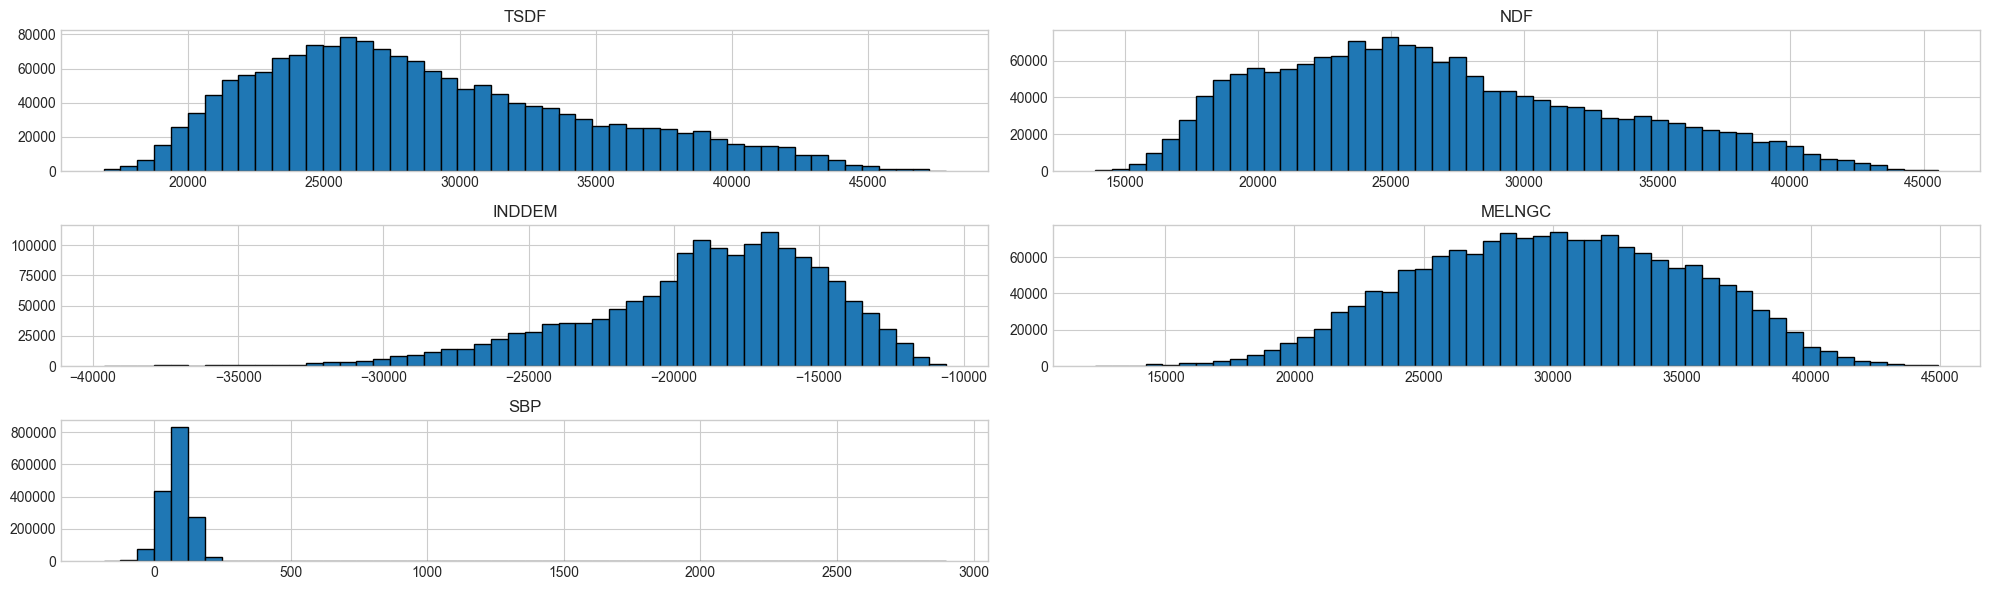

In [11]:
cols_to_plot = ["TSDF","NDF","INDDEM","MELNGC","SBP"]
plot_histograms(df, cols_to_plot=cols_to_plot, bins=50, figsize=(20,6))

- TSDF/NDF : centrées autour de 25–30k.
- INDDEM : peut être négatif (jusqu’à -30 000).
- SBP : majoritairement entre 0 et 200, mais avec des pics allant jusqu’à 2900.

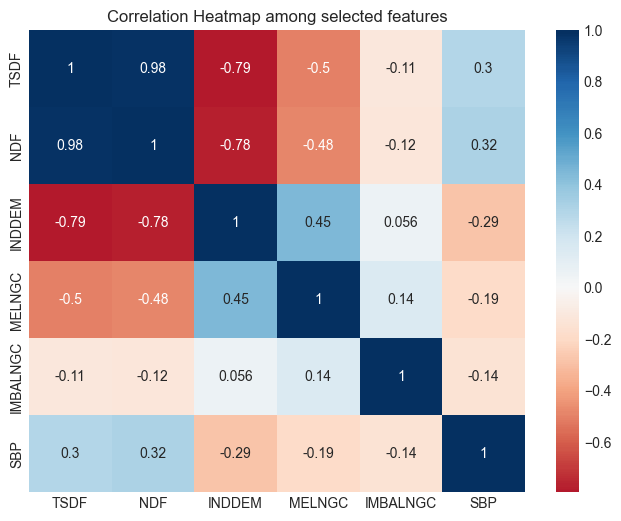

In [12]:
corr_cols = ["TSDF","NDF","INDDEM","MELNGC","IMBALNGC","SBP"]
plot_correlation_heatmap(df, corr_cols=corr_cols, figsize=(8,6))

- TSDF et NDF sont très corrélés (0.98).
- INDDEM est fortement négatif avec TSDF/NDF (~ -0.9).
- SBP a une corrélation modérée (~0.2) avec TSDF/NDF.
- Cela suggère que la demande n’explique qu’une partie du prix, d’où l’intérêt d’autres variables (IMBALNGC, etc.).

In [ ]:
... suite pour autre colonnes

### Analyse spécifique de certaines colonnes
Par exemple, nous examinons les colonnes massivement vides ou potentiellement utiles:
- `reserveScarcityPrice`
- `replacementPrice`
- `replacementPriceReferenceVolume`
- `totalSystemTaggedAdjustmentSellVolume`
- `totalSystemTaggedAdjustmentBuyVolume`

=== Analyse for column: reserveScarcityPrice ===
Total rows: 1660516, NaN count: 416325 (25.07%)

Descriptive stats for non-null values:
count    1.244191e+06
mean     5.644918e-01
std      1.545432e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.088160e+03
Name: reserveScarcityPrice, dtype: float64


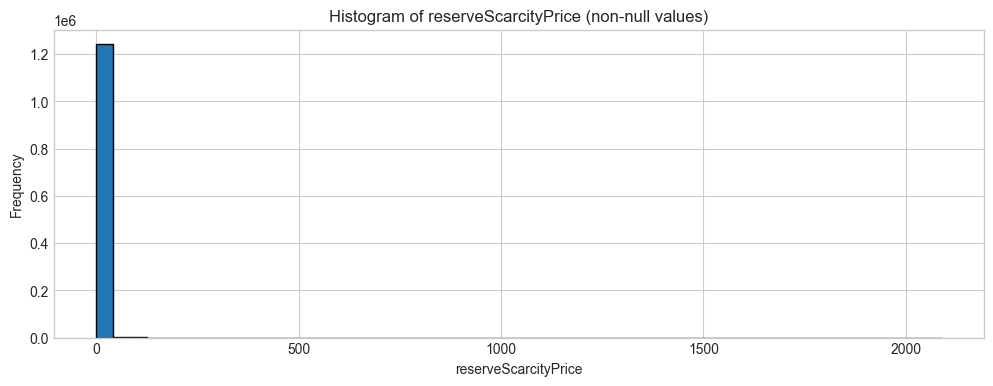

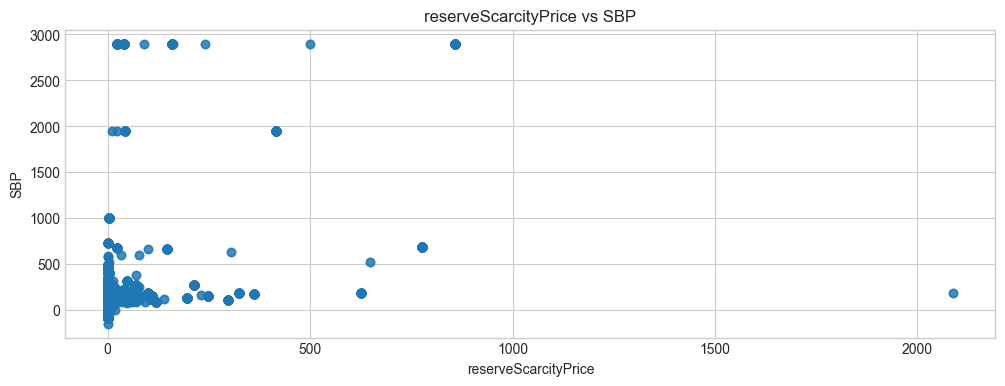



=== Analyse for column: replacementPrice ===
Total rows: 1660516, NaN count: 1362014 (82.02%)

Non-numeric or empty. Skipping descriptive stats.


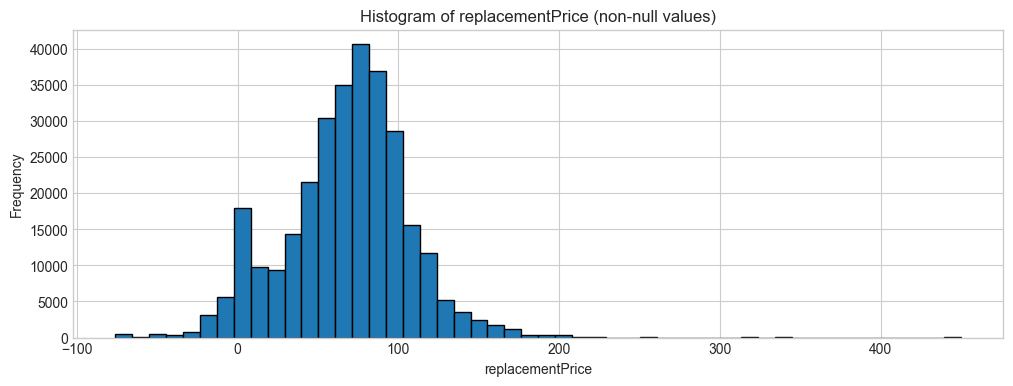

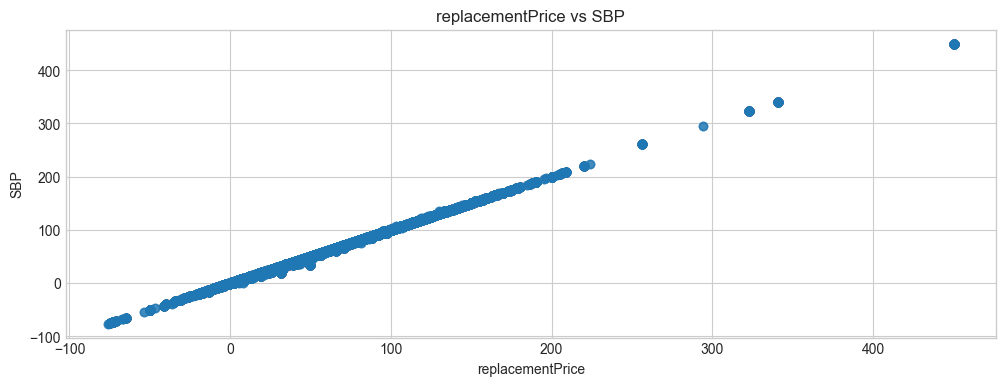



=== Analyse for column: replacementPriceReferenceVolume ===
Total rows: 1660516, NaN count: 1362014 (82.02%)

Non-numeric or empty. Skipping descriptive stats.


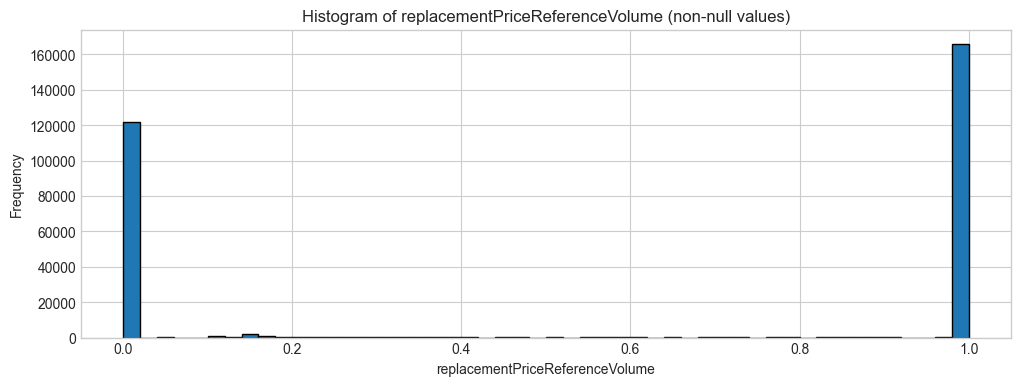

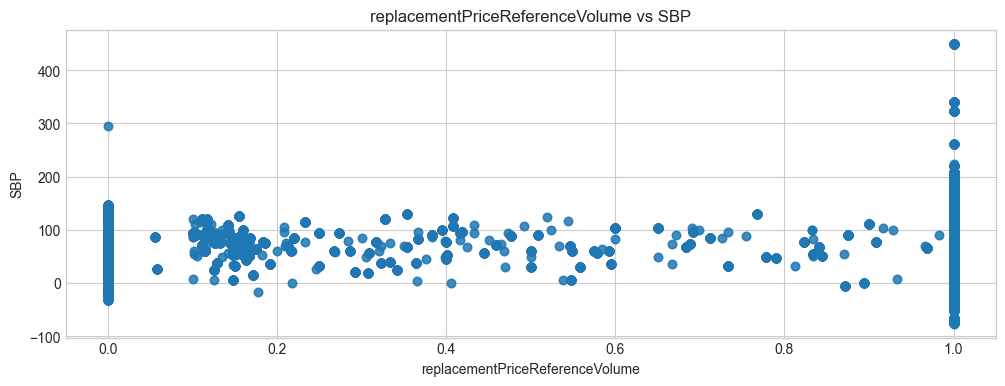



=== Analyse for column: totalSystemTaggedAdjustmentSellVolume ===
Total rows: 1660516, NaN count: 678059 (40.83%)

Non-numeric or empty. Skipping descriptive stats.


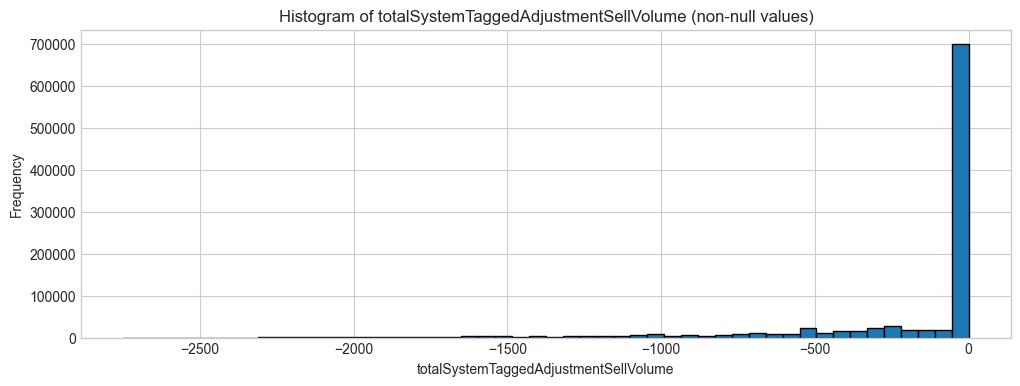

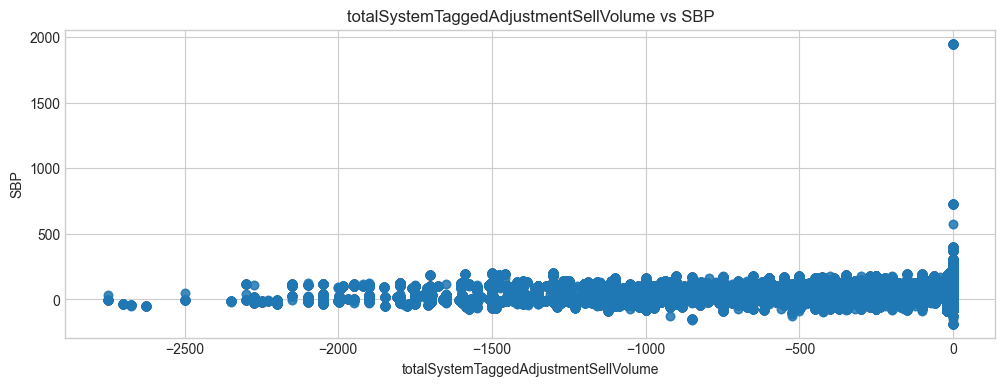



=== Analyse for column: totalSystemTaggedAdjustmentBuyVolume ===
Total rows: 1660516, NaN count: 354851 (21.37%)

Descriptive stats for non-null values:
count    1.305665e+06
mean     1.905808e+02
std      2.613528e+02
min      0.000000e+00
25%      0.000000e+00
50%      9.511100e+01
75%      2.752000e+02
max      3.099000e+03
Name: totalSystemTaggedAdjustmentBuyVolume, dtype: float64


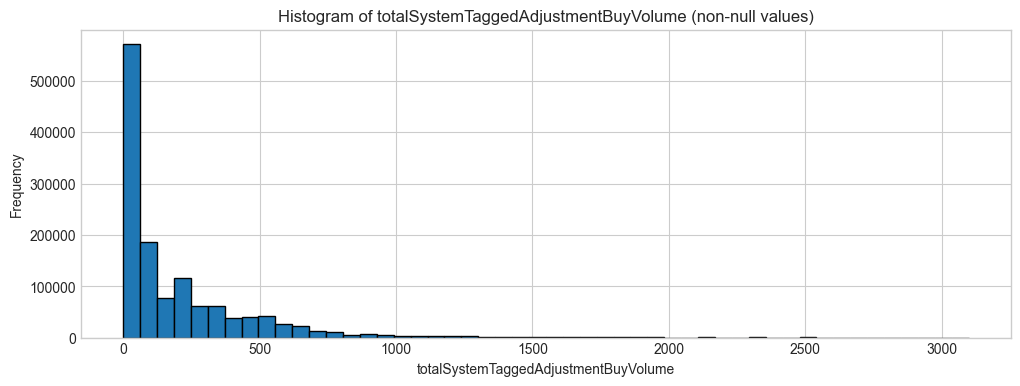

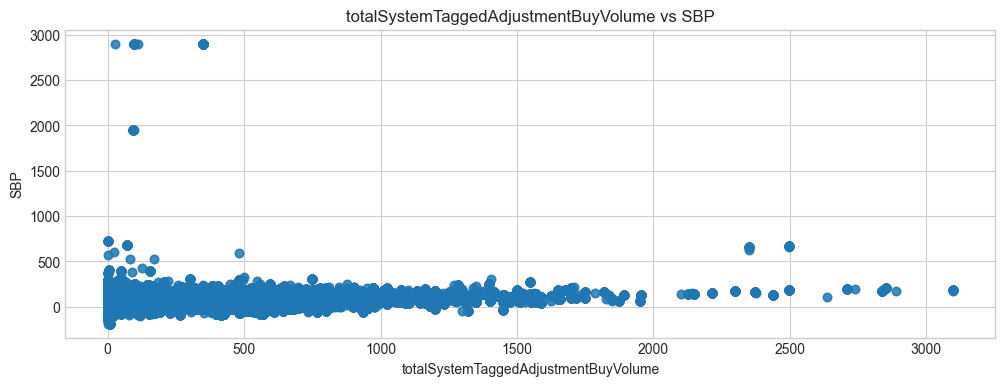

In [13]:
cols_to_analyze = ["reserveScarcityPrice", "replacementPrice", "replacementPriceReferenceVolume", "totalSystemTaggedAdjustmentSellVolume", "totalSystemTaggedAdjustmentBuyVolume"]

for col in cols_to_analyze:
    analyze_column(df, col_name=col, sbp_col="SBP")

**1. `reserveScarcityPrice`**  
- Majoritairement à 0, quelques pics rares.  
- ~27 % de valeurs manquantes.  
- Légère corrélation avec certains pics de SBP.  
- **Décision** : Conserver et imputer les NaN par 0.

**2. `replacementPrice`**  
- Distribution ~0–200, corrélation marquée avec SBP sur la portion non-nulle.  
- ~82 % de NaN => très peu de données exploitables.  
- **Décision** : Supprimer (trop de valeurs manquantes).

**3. `replacementPriceReferenceVolume`**  
- Souvent 0 ou 1, faible corrélation avec SBP.  
- ~82 % de NaN, même souci que `replacementPrice`.  
- **Décision** : Supprimer.

**4. `totalSystemTaggedAdjustmentSellVolume`**  
- Large éventail (négatif/positif), ~36 % de NaN.  
- Pas de relation nette avec SBP.  
- **Décision** : Supprimer (imputation incertaine).

**5. `totalSystemTaggedAdjustmentBuyVolume`**  
- ~20 % de NaN, valeurs surtout <500, corrélation faible.  
- **Décision** : Possibilité d’imputer à 0, mais on préfère supprimer.

**En résumé** : On **conserve** `reserveScarcityPrice` (avec imputation 0) et on **supprime** les autres colonnes.

=== Analyse for column: gen_INTGRNL ===
Total rows: 1660516, NaN count: 1131082 (68.12%)

Descriptive stats for non-null values:
count    529434.000000
mean        -22.959576
std         152.781783
min        -514.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         506.000000
Name: gen_INTGRNL, dtype: float64


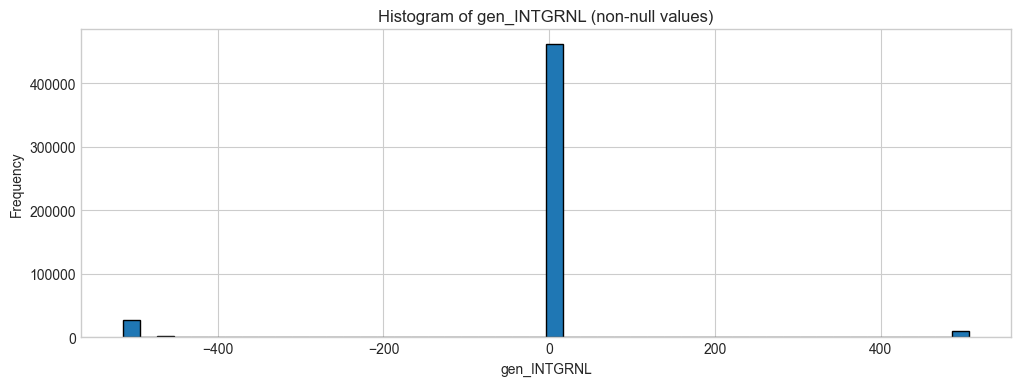

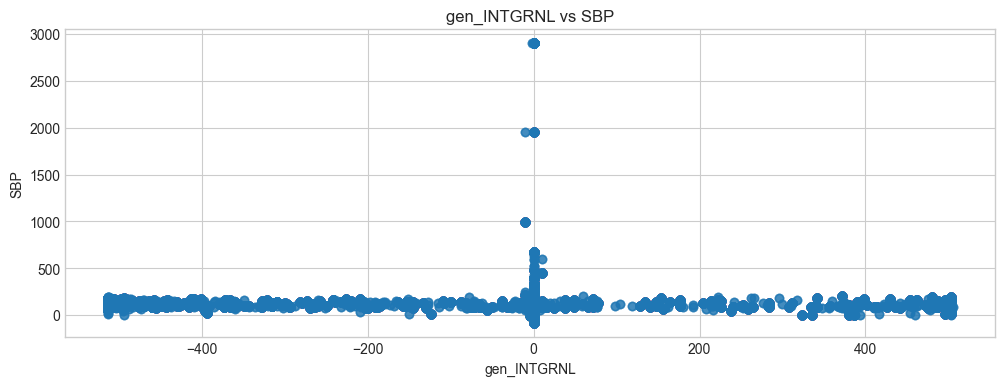



=== Analyse for column: gen_INTVKL ===
Total rows: 1660516, NaN count: 596216 (35.91%)

Descriptive stats for non-null values:
count    1.064300e+06
mean     4.196817e+02
std      7.333328e+02
min     -1.460000e+03
25%      0.000000e+00
50%      5.660000e+02
75%      9.880000e+02
max      1.436000e+03
Name: gen_INTVKL, dtype: float64


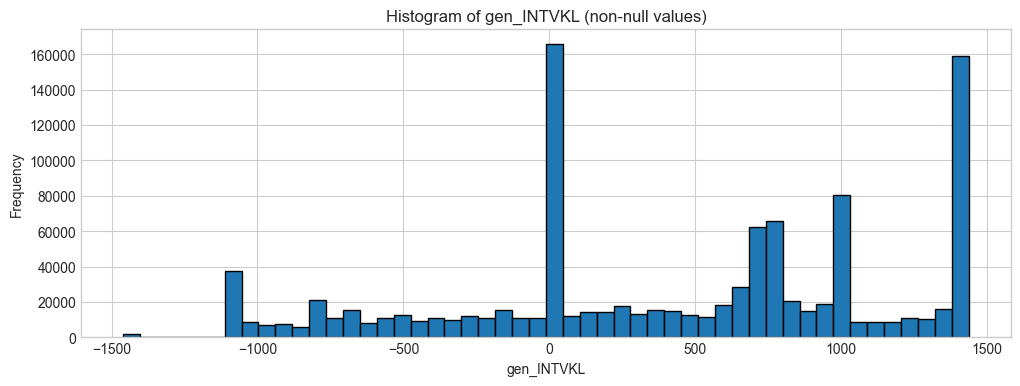

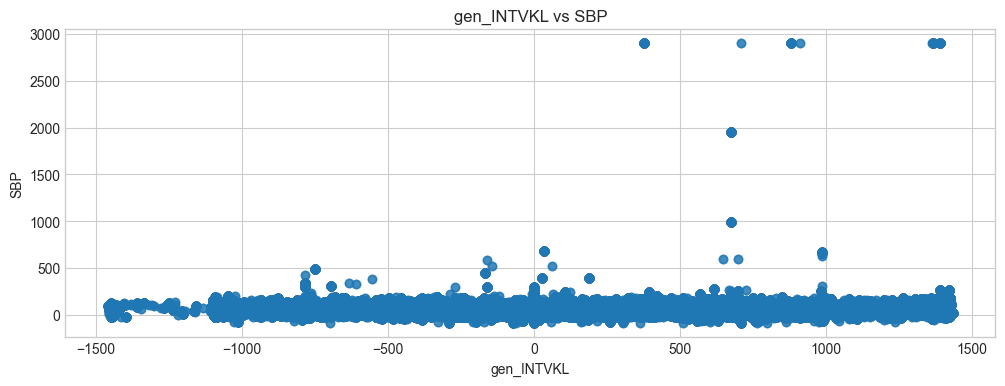



=== Analyse for column: windForecast ===
Total rows: 1660516, NaN count: 89077 (5.36%)

Descriptive stats for non-null values:
count    1.571439e+06
mean     8.349083e+03
std      4.938731e+03
min      3.060000e+02
25%      3.987000e+03
50%      7.655000e+03
75%      1.221100e+04
max      2.049900e+04
Name: windForecast, dtype: float64


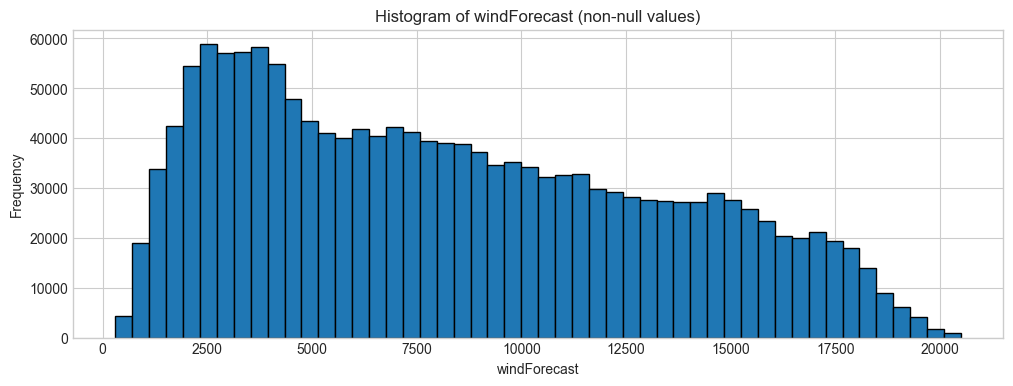

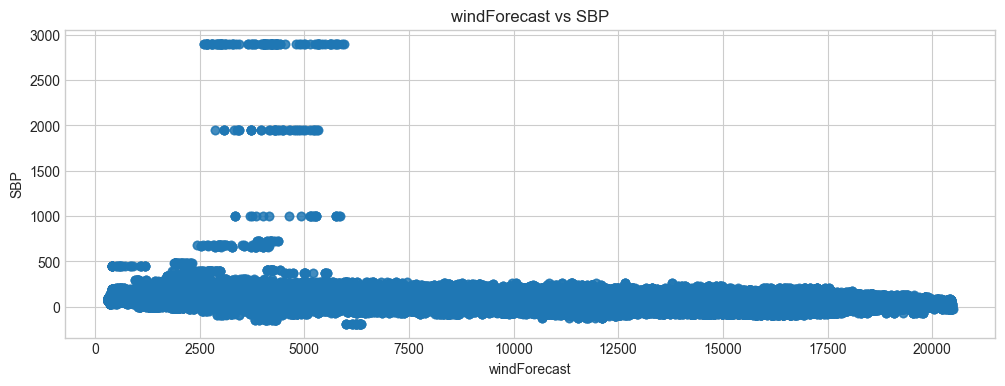

In [14]:
cols_to_analyze = ["gen_INTGRNL", "gen_INTVKL", "windForecast"]

for col in cols_to_analyze:
    analyze_column(df, col_name=col, sbp_col="SBP")

| **Colonne**       | **% de NaN** | **Analyse**                                                                                       | **Décision**                                   |
|-------------------|-------------:|---------------------------------------------------------------------------------------------------|------------------------------------------------|
| **gen_INTGRNL**   | 68.1%        | Majoritairement à 0, peu de variabilité, corrélation faible avec SBP.                             | Supprimer.                               |
| **gen_INTVKL**    | 35.9%        | Variabilité plus importante, certains pics marqués.                                               | Supprimer.                               |
| **windForecast**  | 5.36%        | Corrélation claire avec SBP, impact potentiel sur la volatilité des prix.                         | Conserver et interpoler les NaN.               |

#### Constats Clés de l’EDA

- **SBP négatifs (~5 %)** : On observe qu’environ 5 % des valeurs de SBP sont inférieures à 0, majoritairement la nuit (0–4 h) et le week-end (jour 6 = dimanche). Cela indique souvent un surplus d’offre (faible demande) conduisant à des prix négatifs.  
- **Forte corrélation TSDF–NDF (~0.98)** : Les deux prévisions de la demande se recoupent fortement.  
- **Pics extrêmes (SBP > 2000)** : Quelques événements rares atteignent 2 500–3 000, ce qui accroît la volatilité et influence le RMSE.  
- **Variables IMBALNGC, MELNGC, INDDEM** : Elles présentent une corrélation modérée avec SBP (typ. -0.15 à -0.30), reflétant l’impact du surplus/déficit. Cependant, aucune variable ne suffit à elle seule à expliquer les fluctuations.  
- **Répartition temporelle** : Les valeurs négatives et les pics se produisent sur toute la période, mais avec une saisonnalité marquée (nuit, week-end, potentiellement certains mois).  

En résumé, le marché présente :
- Une distribution très asymétrique du SBP (concentration autour de 0–100 et quelques pics extrêmes).  
- Des corrélations fortes entre certaines variables de demande (TSDF, NDF), mais des liens plus modestes avec SBP.  
- Des valeurs manquantes significatives pour certaines colonnes (ex. replacementPrice), justifiant leur suppression ou imputation.

Ces observations orientent nos choix de **feature engineering** (ajout de variables temporelles, gestion des valeurs extrêmes) et la **stratégie de modélisation** (modèle robuste à la forte volatilité, éventuel log-transform).

## 5. Nettoyage et Préparation des Données <a name="nettoyage-et-préparation-des-données"></a>

Dans cette section, nous appliquons les règles de nettoyage et de préparation identifiées lors de l’EDA :

1. **Gérer les valeurs manquantes** pour les colonnes essentielles (SBP, NDF, INDDEM, MELNGC, etc.).
2. **Ajouter** des features temporelles (heure, jour de la semaine, mois).
3. **Nettoyer** ou **supprimer** les colonnes massivement vides (replacementPrice, etc.).
4. **Imputer** certaines colonnes (ex. reserveScarcityPrice à 0).
5. **Vérifier** et décider du traitement des SBP négatifs (ici, on les conserve)

In [19]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Nettoyage spécifique des colonnes identifiées comme massivement vides ou nécessitant une imputation
    """
    
    # Imputation reserveScarcityPrice
    if "reserveScarcityPrice" in df.columns:
        df["reserveScarcityPrice"].fillna(0, inplace=True)
        print("[Info] reserveScarcityPrice: NaN -> 0.")
    else:
        print("[Warning] reserveScarcityPrice not in df.")
    
    # Suppression replacementPrice
    if "replacementPrice" in df.columns:
        df.drop(columns=["replacementPrice"], inplace=True)
        print("[Info] replacementPrice dropped (massively missing).")
    else:
        print("[Warning] replacementPrice not in df.")
    
    # Suppression replacementPriceReferenceVolume
    if "replacementPriceReferenceVolume" in df.columns:
        df.drop(columns=["replacementPriceReferenceVolume"], inplace=True)
        print("[Info] replacementPriceReferenceVolume dropped (massively missing).")
    else:
        print("[Warning] replacementPriceReferenceVolume not in df.")
    
    # Suppression totalSystemTaggedAdjustmentSellVolume
    if "totalSystemTaggedAdjustmentSellVolume" in df.columns:
        df.drop(columns=["totalSystemTaggedAdjustmentSellVolume"], inplace=True)
        print("[Info] totalSystemTaggedAdjustmentSellVolume dropped (~36% missing).")
    else:
        print("[Warning] totalSystemTaggedAdjustmentSellVolume not in df.")
    
    # Suppression totalSystemTaggedAdjustmentBuyVolume
    if "totalSystemTaggedAdjustmentBuyVolume" in df.columns:
        df.drop(columns=["totalSystemTaggedAdjustmentBuyVolume"], inplace=True)
        print("[Info] totalSystemTaggedAdjustmentBuyVolume dropped (~20% missing).")
    else:
        print("[Warning] totalSystemTaggedAdjustmentBuyVolume not in df.")

    # Suppression gen_INTGRNL (majoritairement à 0, ~68% NaN)
    if "gen_INTGRNL" in df.columns:
        df.drop(columns=["gen_INTGRNL"], inplace=True)
        print("[Info] gen_INTGRNL dropped (~68% missing).")
    else:
        print("[Warning] gen_INTGRNL not in df.")
    
    # Suppression gen_INTVKL (~36% NaN)
    if "gen_INTVKL" in df.columns:
        df.drop(columns=["gen_INTVKL"], inplace=True)
        print("[Info] gen_INTVKL dropped (~36% missing).")
    else:
        print("[Warning] gen_INTVKL not in df.")

    # Conserver windForecast, interpolation des NaN
    if "windForecast" in df.columns:
        # Exemple d'interpolation par le temps (si l'index est un DatetimeIndex régulier)
        df["windForecast"] = df["windForecast"].interpolate(method="time", limit_direction="forward")
        print("[Info] windForecast: NaN interpolated (method='time').")
    else:
        print("[Warning] windForecast not in df.")
        
    return df

In [20]:
df = clean_columns(df)

[Info] reserveScarcityPrice: NaN -> 0.
[Info] replacementPrice dropped (massively missing).
[Info] replacementPriceReferenceVolume dropped (massively missing).
[Info] totalSystemTaggedAdjustmentSellVolume dropped (~36% missing).
[Info] totalSystemTaggedAdjustmentBuyVolume dropped (~20% missing).
[Info] gen_INTGRNL dropped (~68% missing).
[Info] gen_INTVKL dropped (~36% missing).
[Info] windForecast: NaN interpolated (method='time').


In [21]:
# Aperçu des colonnes
print("Liste des colonnes du DataFrame:")
print(df.columns)

print("\nValeurs manquantes par colonne:")
missing_counts = df.isnull().sum()
print(missing_counts)

# Petit commentaire sur la proportion de NaN
n_total = len(df)
missing_info = (missing_counts / n_total * 100).sort_values(ascending=False)
print("\nPourcentage de NaN (top 20):")
print(missing_info.head(20))

Liste des colonnes du DataFrame:
Index(['TSDF', 'NDF', 'INDGEN', 'INDDEM', 'MELNGC', 'IMBALNGC', 'SSP', 'SBP',
       'bsadDefaulted', 'priceDerivationCode', 'reserveScarcityPrice', 'NIV',
       'sellPriceAdjustment', 'buyPriceAdjustment', 'totalAcceptedOfferVolume',
       'totalAcceptedBidVolume', 'totalAdjustmentSellVolume',
       'totalAdjustmentBuyVolume', 'totalSystemTaggedAcceptedOfferVolume',
       'totalSystemTaggedAcceptedBidVolume', 'MID_price', 'MID_volume',
       'gen_BIOMASS', 'gen_CCGT', 'gen_COAL', 'gen_INTELEC', 'gen_INTEW',
       'gen_INTFR', 'gen_INTIFA2', 'gen_INTIRL', 'gen_INTNED', 'gen_INTNEM',
       'gen_INTNSL', 'gen_NPSHYD', 'gen_NUCLEAR', 'gen_OCGT', 'gen_OIL',
       'gen_OTHER', 'gen_PS', 'gen_WIND', 'windForecast', 'startTime_sys',
       'forecastHorizon', 'lolp', 'deratedMargin'],
      dtype='object')

Valeurs manquantes par colonne:
TSDF                                      544
NDF                                     15476
INDGEN                  

In [44]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Supprime les lignes où certaines colonnes clés sont NaN.
    Les colonnes jugées essentielles sont : 
      - 'SBP', 'NDF', 'INDDEM', 'MELNGC', 'IMBALNGC', 
      - 'totalSystemTaggedAcceptedOfferVolume', 'totalSystemTaggedAcceptedBidVolume'.

    Retourne le DataFrame filtré.
    """
    required_cols = [
        "SBP", "NDF", "INDDEM", "MELNGC", "IMBALNGC",
        "totalSystemTaggedAcceptedOfferVolume", 
        "totalSystemTaggedAcceptedBidVolume"
    ]
    df = df.dropna(subset=required_cols).copy()
    return df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ajoute des features temporelles (hour, dayofweek, month)
    basées sur l'index Datetime.
    """
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    return df

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pipeline simple de préprocessing :
      1) handle_missing_values : supprime les lignes 
         avec NaN sur colonnes clés.
      2) add_time_features : ajoute hour, dayofweek, month.
    """
    df = handle_missing_values(df)
    df = add_time_features(df)
    return df

In [45]:
df = preprocess_data(df)

#### Pourquoi y a-t-il des SBP négatifs et que faire ?

In [17]:
def check_negative_sbp(df: pd.DataFrame, sbp_col: str = "SBP"):
    """
    Vérifie la proportion de SBP < 0 et affiche
    quelques stats descriptives si présent.
    """
    neg_count = (df[sbp_col] < 0).sum()
    total = len(df)
    if neg_count > 0:
        print(f"[check_negative_sbp] Found {neg_count} negative SBP values out of {total} "
              f"({100*neg_count/total:.2f}%).")
        print(df.loc[df[sbp_col] < 0, sbp_col].describe())
    else:
        print("[check_negative_sbp] No negative SBP found.")

In [18]:
check_negative_sbp(df)

[check_negative_sbp] Found 1807 negative SBP values out of 34436 (5.25%).
count    1807.000000
mean      -24.396482
std        22.724601
min      -185.330000
25%       -29.560000
50%       -19.190000
75%        -8.000000
max        -0.080000
Name: SBP, dtype: float64


In [19]:
df_negative_sbp = df[df["SBP"] < 0][["settlementDate_sys", "settlementPeriod_sys", "TSDF", "NDF", "INDDEM", "MELNGC", "IMBALNGC", "hour", "dayofweek", "month", "reserveScarcityPrice", "SBP"]]

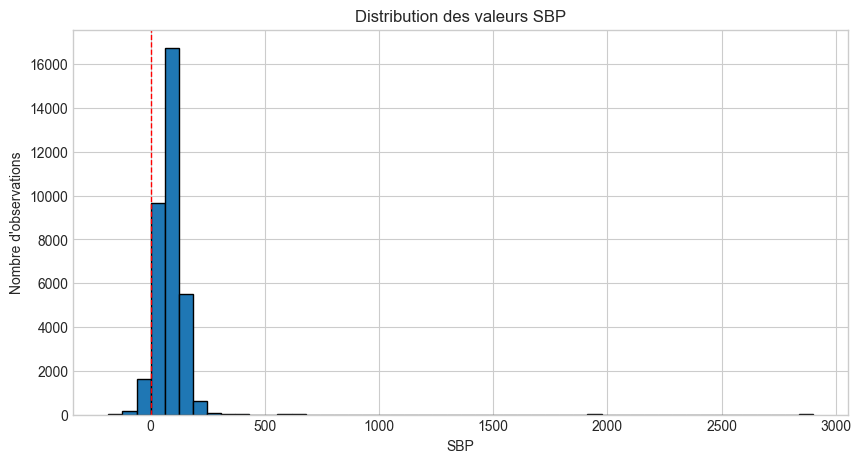

In [20]:
plt.figure(figsize=(10, 5))
df["SBP"].hist(bins=50, edgecolor="black")
plt.axvline(0, color="red", linestyle="dashed", linewidth=1) # Ligne rouge à zéro
plt.title("Distribution des valeurs SBP")
plt.xlabel("SBP")
plt.ylabel("Nombre d'observations")
plt.show()

- La plupart des valeurs sont entre 0 et 200, quelques pics > 1 000.
- ~5 % en dessous de 0, jusqu’à -185.

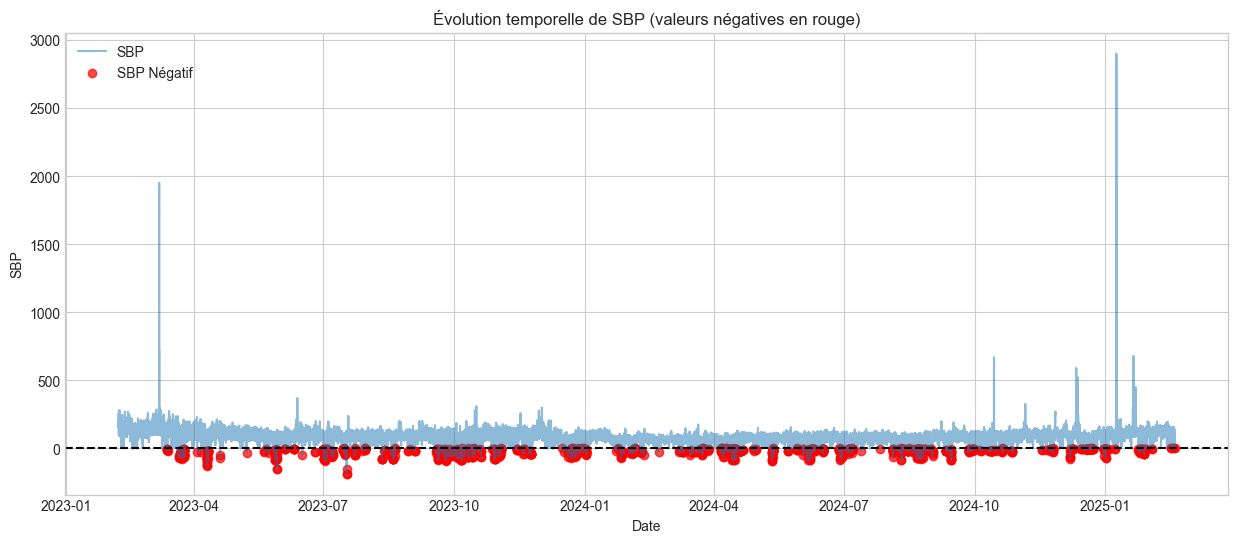

In [21]:
df["SBP_negative"] = df["SBP"] < 0
df_neg = df[df["SBP_negative"]]

plt.figure(figsize=(15, 6))
plt.plot(df.index, df["SBP"], label="SBP", alpha=0.5)
plt.scatter(df_neg.index, df_neg["SBP"], color="red", label="SBP Négatif", alpha=0.7)
plt.axhline(0, color="black", linestyle="dashed")
plt.title("Évolution temporelle de SBP (valeurs négatives en rouge)")
plt.xlabel("Date")
plt.ylabel("SBP")
plt.legend()
plt.show()

- Les SBP négatifs se répartissent dans toute la période,
- Les pics extrêmes (jusqu’à 2 900) sont rares et ponctuels,
- Indique un marché potentiellement en surplus lors de ces phases négatives.

In [22]:
df_negative_sbp.describe()

,settlementPeriod_sys,TSDF,NDF,INDDEM,MELNGC,IMBALNGC,hour,dayofweek,month,reserveScarcityPrice,SBP
count,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.0,1807.000000
mean,19.256779,23718.252905,20465.503597,-16873.115661,32126.511345,1015.238517,8.742667,3.795794,7.238517,0.0,-24.396482
std,12.591962,3006.225698,3668.314757,2653.109956,4329.039480,1236.900846,6.475755,2.054308,3.118036,0.0,22.724601
min,1.000000,16892.000000,13880.000000,-32244.000000,20630.000000,-3561.000000,0.000000,0.000000,1.000000,0.0,-185.330000
25%,8.000000,21641.000000,17744.500000,-17774.000000,29075.000000,323.500000,3.000000,2.000000,4.000000,0.0,-29.560000
50%,18.000000,23545.000000,19738.000000,-16489.000000,32805.000000,1116.000000,8.000000,4.000000,7.000000,0.0,-19.190000
75%,28.000000,25219.500000,22321.500000,-15330.000000,35180.500000,1806.500000,13.000000,6.000000,10.000000,0.0,-8.000000
max,48.000000,37280.000000,35770.000000,-11920.000000,42631.000000,5557.000000,23.000000,6.000000,12.000000,0.0,-0.080000


- IMBALNGC moyen = 1015.75 (ce qui est relativement élevé, indiquant souvent un surplus d’énergie).
- MELNGC ~ 32 113 en moyenne (plutôt élevé également).
- INDDEM ~ -16 872, indiquant possiblement un solde net (ou un “négatif” signifiant un excès de production vs. consommation).
- IMBALNGC > 0 indique souvent un excès d’énergie ; on peut faire l’hypothèse qu’un SBP négatif survient quand le système est sur-approvisionné.

Les indicateurs (IMBALNGC, INDDEM) laissent penser qu’on a un surplus d’énergie lors de ces périodes. Les valeurs ne sont pas marginales (jusqu’à -185).

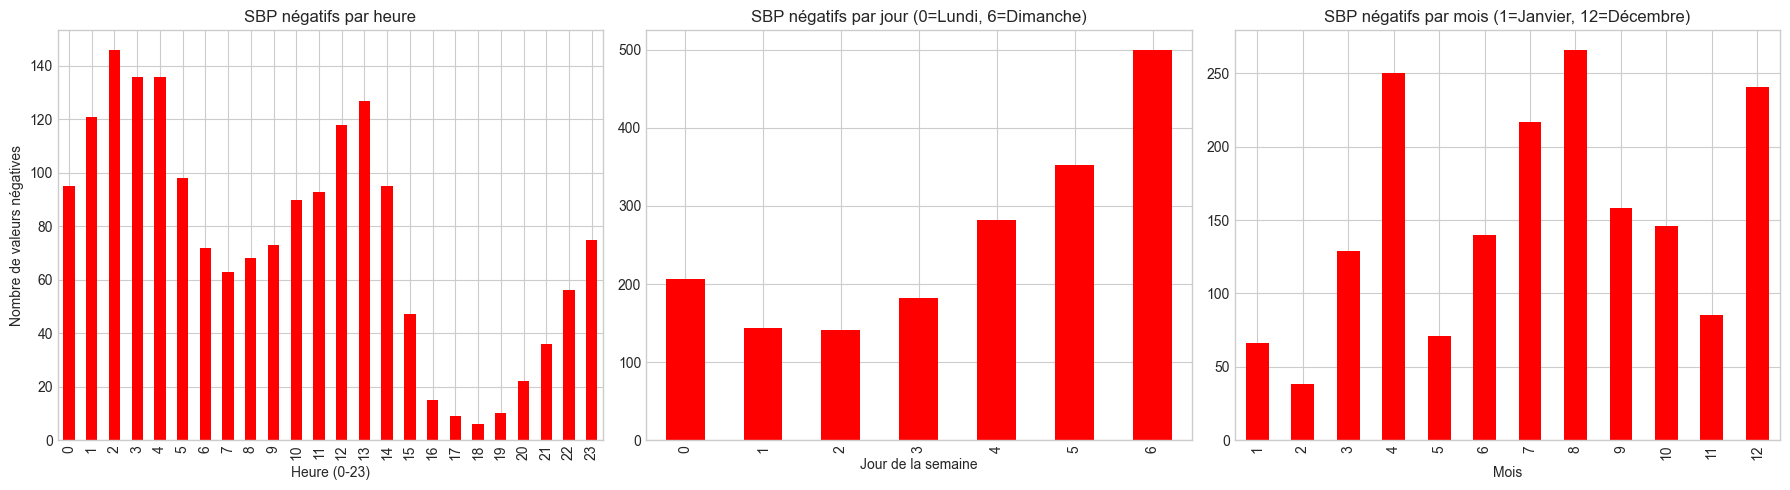

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Histogramme des valeurs négatives par heure
df_neg["hour"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[0]
)
axes[0].set_title("SBP négatifs par heure")
axes[0].set_xlabel("Heure (0-23)")
axes[0].set_ylabel("Nombre de valeurs négatives")

# 2) Histogramme des valeurs négatives par jour de la semaine
df_neg["dayofweek"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[1]
)
axes[1].set_title("SBP négatifs par jour (0=Lundi, 6=Dimanche)")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("")

# 3) Histogramme des valeurs négatives par mois
df_neg["month"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[2]
)
axes[2].set_title("SBP négatifs par mois (1=Janvier, 12=Décembre)")
axes[2].set_xlabel("Mois")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

**Analyse consolidée des SBP négatifs par heure, jour et mois :**

- **Par heure** : On constate un pic de valeurs négatives la nuit (environ 0–4 h) et en fin de soirée (22–23 h).  
  &nbsp;&nbsp;&rarr; **Interprétation** : Durant ces plages horaires, la demande est beaucoup plus faible, créant un surplus d’énergie et donc un prix potentiellement sous zéro.

- **Par jour de la semaine** : Le week-end, surtout le dimanche (jour 6), présente le plus de SBP négatifs.  
  &nbsp;&nbsp;&rarr; **Interprétation** : La consommation industrielle/commerciale chute généralement le dimanche, favorisant un excès d’offre et une baisse de prix.

- **Par mois** : Certains mois (en hiver ou en été) enregistrent davantage de SBP négatifs, tandis que d’autres en ont moins.  
  &nbsp;&nbsp;&rarr; **Interprétation** : Il s’agit probablement d’une **saisonnalité** liée à la production renouvelable (vent/soleil) et aux variations de la demande (chauffage, climatisation).  

Dans l’ensemble, ces graphiques soulignent que les **SBP négatifs** se produisent régulièrement, principalement lors de **faible demande** ou d’**excès d’offre** (nuit, dimanche, saison creuse), confirmant un phénomène de marché réel plutôt qu’une anomaie isolée.


# 6. Feature Engineering <a name="feature-engineering"></a>

Dans cette section, nous ajoutons ou transformons des variables (ex. colonnes temporelles, éventuel shift+log de SBP, etc.)

In [24]:
def apply_sbp_transform(df: pd.DataFrame, shift_log: bool = False, offset: float = None) -> (pd.DataFrame, str):
    """
    Si shift_log=True, applique un offset pour gérer SBP négatif, puis log.
    Crée deux colonnes:
      - SBP_shift = SBP + offset
      - SBP_log   = log(SBP_shift)
    Retourne (df_modifie, nom_col_target).
    """
    if shift_log:
        # Calcul automatique de l'offset si pas fourni
        if offset is None:
            sbp_min = df["SBP"].min()
            offset = abs(sbp_min) + 1  # ex: ~186.33 si min = -185.33

        df["SBP_shift"] = df["SBP"] + offset
        df["SBP_log"] = np.log(df["SBP_shift"])
        target_col = "SBP_log"
        print(f"[Info] shift+log transform with offset={offset:.2f} => target = {target_col}")
    else:
        target_col = "SBP"  # SBP brut
        print("[Info] Using SBP as target (raw scale).")

    return df, target_col

In [27]:
df, target_col = apply_sbp_transform(df, shift_log=False)

[Info] Using SBP as target (raw scale).


In [28]:
df_shift_log, target_col_shift_log = apply_sbp_transform(df, shift_log=True)

[Info] shift+log transform with offset=186.33 => target = SBP_log


# 7. Séparation Train/Test et Pipeline de Modélisation <a name="séparation-traintest-et-pipeline-de-modélisation"></a>

Ici, nous faisons un split temporel:
1. Train: 2023-02-15 à 2024-12-31
2. Test: 2025-01-01 à 2025-02-15
3. Ensuite, nous construisons une fonction pipeline final (`final_pipeline`).

In [29]:
def split_train_test(df: pd.DataFrame, train_start: str, train_end: str, test_start: str, test_end: str) -> (pd.DataFrame, pd.DataFrame):
    """
    Effectue un split temporel sur df.index (DatetimeIndex).
    Retourne (df_train, df_test).
    """
    df_train = df.loc[train_start:train_end].copy()
    df_test  = df.loc[test_start:test_end].copy()
    print(f"[Info] Train range: {train_start} to {train_end}, {len(df_train)} rows.")
    print(f"[Info] Test range:  {test_start} to {test_end}, {len(df_test)} rows.")
    return df_train, df_test

In [31]:
df_train, df_test = split_train_test(df, "2023-02-07", "2024-12-31", "2025-01-01", "2025-02-18")

[Info] Train range: 2023-02-07 to 2024-12-31, 32245 rows.
[Info] Test range:  2025-01-01 to 2025-02-18, 2191 rows.


In [36]:
df_train_shift_log, df_test_shift_log = split_train_test(df_shift_log, "2023-02-07", "2024-12-31", "2025-01-01", "2025-02-18")

[Info] Train range: 2023-02-07 to 2024-12-31, 32245 rows.
[Info] Test range:  2025-01-01 to 2025-02-18, 2191 rows.


# 8. Entraînement du Modèle <a name="entraînement-du-modèle"></a>

In [ ]:
features = ["TSDF","NDF","INDDEM","IMBALNGC","hour","dayofweek","month","reserveScarcityPrice"]

**Justification des Features Sélectionnées**

1. **TSDF (Transmission System Demand Forecast)**  
   - **Définition :** Estimation de la demande électrique sur le réseau de transport, fournie par le gestionnaire de réseau (NGESO).  
   - **Raison d’inclusion :** Les variations de demande influencent directement les prix : une demande élevée peut soutenir des prix plus hauts, et inversement.

2. **NDF (National Demand Forecast)**  
   - **Définition :** Prévision de la demande électrique au niveau national (incluant les pertes de transport).  
   - **Raison d’inclusion :** Donne une vision agrégée de la consommation en GB. Les fluctuations de la demande nationale sont un déterminant majeur du prix.

3. **INDDEM (Indicated Demand)**  
   - **Définition :** Indication de la demande (day-ahead ou intraday), publiée par NGESO, reflétant l’offre/demande réelle attendue.  
   - **Raison d’inclusion :** Lorsque la demande indiquée est très basse (surplus d’offre), le prix peut chuter ou devenir négatif.

4. **IMBALNGC (Indicated Imbalance)**  
   - **Définition :** Indication de l’écart prévu entre l’offre et la demande. Un écart important (surplus ou déficit) impacte fortement le prix.  
   - **Raison d’inclusion :** Un surplus prononcé peut engendrer des prix négatifs, tandis qu’un déficit peut pousser les prix à la hausse.

5. **hour** *(Heure de la journée)*  
   - **Définition :** Extraite de l’index temporel (valeurs 0 à 23).  
   - **Raison d’inclusion :** Les prix varient fortement selon l’heure (pics de demande matin/soir, creux la nuit). Cette variable permet de capturer la structure intrajournalière.

6. **dayofweek** *(Jour de la semaine)*  
   - **Définition :** 0 = Lundi, …, 6 = Dimanche.  
   - **Raison d’inclusion :** Les comportements de consommation et de production diffèrent selon le jour (le week-end, l’activité industrielle est plus faible, etc.). Cela influence la formation des prix.

7. **month** *(Mois de l’année)*  
   - **Définition :** 1 = Janvier, …, 12 = Décembre.  
   - **Raison d’inclusion :** La demande et la production présentent une forte saisonnalité (hiver vs. été, périodes de vacances, etc.). Les prix peuvent donc varier selon la saison.

8. **reserveScarcityPrice**  
   - **Définition :** Indicateur de tension sur la réserve, potentiellement > 0 lors d’un risque de manque de capacité.  
   - **Raison d’inclusion :** Les rares occurrences où cette valeur dépasse 0 coïncident souvent avec des pics de prix (pénurie imminente), ce qui peut expliquer certaines extrêmes de SBP.


In [32]:
def train_xgboost(X_train, y_train) -> xgb.XGBRegressor:
    """
    Entraîne un XGBoostRegressor avec quelques hyperparamètres basiques.
    """
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [33]:
X_train = df_train[features]
y_train = df_train[target_col]

X_test = df_test[features]
y_test = df_test[target_col]
model = train_xgboost(X_train, y_train)

In [38]:
X_train_shift_log = df_train_shift_log[features]
y_train_shift_log = df_train_shift_log[target_col_shift_log]

X_test_shift_log = df_test_shift_log[features]
y_test_shift_log = df_test_shift_log[target_col_shift_log]
model_shift_log = train_xgboost(X_train_shift_log, y_train_shift_log)

# 9. Évaluation du Modèle <a name="évaluation-du-modèle"></a>

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test,
                   shift_log: bool = False, offset: float = None):
    """
    Evalue le modèle (train et test) en calculant RMSE, MAE, R². Gère l'inverse log si shift_log=True.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    if shift_log:
        # On repasse en échelle SBP brute
        # SBP_pred = exp(SBP_log_pred) - offset
        y_pred_train_original = np.exp(y_pred_train) - offset
        y_pred_test_original  = np.exp(y_pred_test)  - offset

        y_train_original = np.exp(y_train) - offset
        y_test_original  = np.exp(y_test)  - offset

        rmse_train = (mean_squared_error(y_train_original, y_pred_train_original))**0.5
        rmse_test  = (mean_squared_error(y_test_original,  y_pred_test_original))**0.5

        mae_train  = mean_absolute_error(y_train_original, y_pred_train_original)
        mae_test   = mean_absolute_error(y_test_original,  y_pred_test_original)

        r2_train   = r2_score(y_train, y_pred_train)
        r2_test    = r2_score(y_test,  y_pred_test)

        print(f"[Eval] SHIFT+LOG scenario (offset={offset:.2f})")
        print(f"  Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")
        print(f"  Train MAE:  {mae_train:.2f},  Test MAE:  {mae_test:.2f}")
        print(f"  Train R²:   {r2_train:.2f},   Test R²:   {r2_test:.2f}")

    else:
        # Échelle brute
        rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
        rmse_test  = (mean_squared_error(y_test,  y_pred_test))**0.5

        mae_train  = mean_absolute_error(y_train, y_pred_train)
        mae_test   = mean_absolute_error(y_test,  y_pred_test)

        r2_train   = r2_score(y_train, y_pred_train)
        r2_test    = r2_score(y_test,  y_pred_test)

        print("[Eval] Using SBP raw scale.")
        print(f"  Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")
        print(f"  Train MAE:  {mae_train:.2f},  Test MAE:  {mae_test:.2f}")
        print(f"  Train R²:   {r2_train:.2f},   Test R²:   {r2_test:.2f}")

In [39]:
# On récupère l’offset depuis la fonction apply_sbp_transform si on l’a calculé
offset = abs(df["SBP"].min()) + 1  # ou la valeur que vous aviez calculée

evaluate_model(model, X_train, y_train, X_test, y_test, shift_log=False, offset=offset)

[Eval] Using SBP raw scale.
  Train RMSE: 35.73, Test RMSE: 177.79
  Train MAE:  28.58,  Test MAE:  45.65
  Train R²:   0.52,   Test R²:   0.06


In [40]:
evaluate_model(model_shift_log, X_train_shift_log, y_train_shift_log, X_test_shift_log, y_test_shift_log, shift_log=True, offset=offset)

[Eval] SHIFT+LOG scenario (offset=186.33)
  Train RMSE: 36.37, Test RMSE: 182.62
  Train MAE:  28.74,  Test MAE:  46.63
  Train R²:   0.49,   Test R²:   0.03


# 10. Conclusion et Pistes d'Amélioration <a name="conclusion-et-pistes-damélioration"></a>